In [1]:
# necessary imports

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Because the 1990s had a large number of articles, they had to be run in separate batches. This cell combines the 
# output files into one for later processing.

df_1990s = pd.read_csv('precocity_tuned_1990s_docs_part1.tsv', sep='\t')
df_1994 = pd.read_csv('precocity_tuned_1994s_docs_part2.tsv', sep='\t')

combined_df = pd.concat([df_1990s, df_1994])

combined_df.to_csv('precocity_tuned_1990s_docs.tsv', sep='\t', index=False)

print("Combined file shape:", combined_df.shape)

Combined file shape: (208368, 10)


In [22]:
pwd()

'C:\\Users\\sarah\\Dropbox\\UIUC_FALL_2024\\RA_Underwood\\Novelty_CHR\\topicmodel_v2_results'

In [2]:
meta = pd.read_csv("../all-econ-S2metaWyearcol.tsv", sep = '\t')
print(len(meta))
meta.rename(columns={'paperId': 'docid'}, inplace=True)
meta.set_index('docid', inplace = True)
rschmeta = meta.loc[meta.docSubType == 'research-article', : ]
print(len(rschmeta))
bkrvmeta = meta.loc[meta.docSubType == 'book-review', : ]
print(len(bkrvmeta))

43187
41378
1809


In [3]:
# A function that models the predictive effect of precocity on log(citations),
# while controlling for the effect of time.

def controlled_model(reg_df):

    X = []
    for idx, row in reg_df.iterrows():
        newrow = dict()
        newrow['precocity'] = row['precocity']
        newrow['novelty'] = row['novelty']
        newrow['precocity^2'] = row['precocity'] ** 2
        newrow['logcitations'] = row['logcitations']
        for yr in range(1920, 2000, 5):
            col = 'year' + str(yr)
            if col == 'year1940':
                continue
            if (row['date'] >= yr) and (row['date'] < yr + 5):
                newrow[col] = 1
            else:
                newrow[col] = 0
        X.append(newrow)

    X = pd.DataFrame(X)

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Define the dependent variable
    y = X['logcitations']

    X = X.drop('logcitations', axis=1)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model
    print(model.summary())

def model_novelty_and_transience(reg_df):

    X = []
    for idx, row in reg_df.iterrows():
        newrow = dict()
        newrow['transience'] = row['transience']
        newrow['novelty'] = row['novelty']
        newrow['novelty^2'] = row['novelty'] ** 2
        newrow['transience^2'] = row['transience'] ** 2
        newrow['logcitations'] = row['logcitations']
        for yr in range(1920, 2000, 5):
            col = 'year' + str(yr)
            if (row['date'] >= yr) and (row['date'] < yr + 5):
                newrow[col] = 1
            else:
                newrow[col] = 0
        X.append(newrow)

    X = pd.DataFrame(X)

    # Add a constant to the model (the intercept)
    X = sm.add_constant(X)

    # Define the dependent variable
    y = X['logcitations']

    X = X.drop('logcitations', axis=1)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model
    print(model.summary())

In [4]:
# We also need a function to visualize results over time 

def visualize_results(rlist, ryears):
    df = pd.DataFrame({'year': ryears, 'correlation': rlist})

    minvalue = 0 if min(df['correlation']) >= 0 else min(df['correlation']) - 0.02

    plt.figure(figsize=(10, 6))
    sns.lineplot(df, x='year', y='correlation', marker='o')

    plt.xlabel('Year')
    plt.ylabel('Correlation of precocity with log(citations)')
    plt.title('Strength of correlation')

    plt.ylim(minvalue, max(df['correlation']) + 0.02)

    if minvalue < 0:
        plt.axhline(0, linestyle='--', color='red')

    plt.show()

1920 - 20/0.25/1, n = 1229, -0.00238
1930 - 20/0.25/1, n = 1412, 0.33665
1940 - 20/0.25/1, n = 1545, 0.16835
1950 - 20/0.25/1, n = 3275, 0.33667
1960 - 20/0.25/1, n = 4319, 0.37145
1970 - 20/0.25/1, n = 7272, 0.18605
1980 - 20/0.25/1, n = 6777, 0.26267
1990 - 20/0.25/1, n = 4426, 0.33538


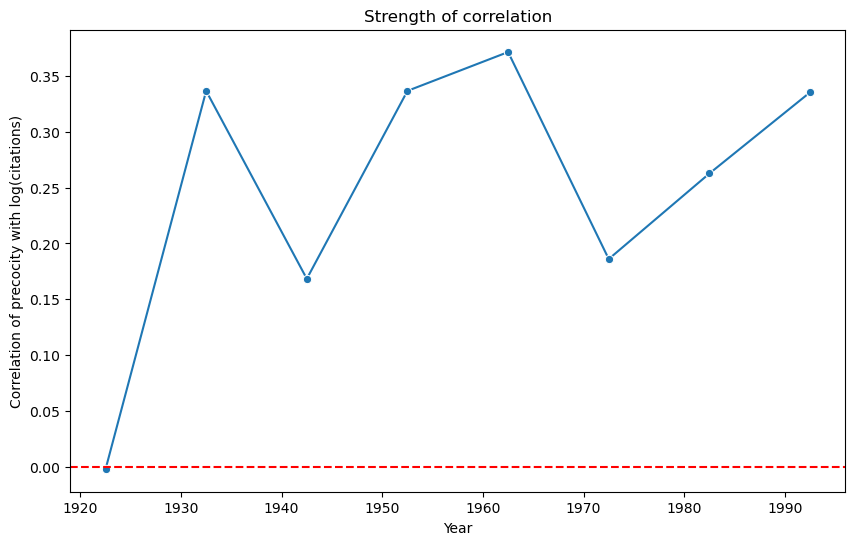

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     890.3
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:34:37   Log-Likelihood:                -57935.
No. Observations:               30255   AIC:                         1.159e+05
Df Residuals:                   30236   BIC:                         1.161e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5996      0.119      5.031      

In [5]:
def run_model(path_to_model, metadata, chunksused = 0.25, fractioncompared = 1.0):
    precocity = []
    novelty = []
    transience = []
    date = []
    logcitations = []
    docids = []
    rlist = []
    ryears = []

    for decade in range(1920, 2000, 10):
        
        data = pd.read_csv(path_to_model + str(decade) + 's_docs.tsv', sep = '\t')

        data.set_index('docid', inplace=True)

        data = data.join(metadata['citationCount'], how='inner')
        data['logcitations'] = np.log(data.citationCount + 1)

        selected = data.loc[(data.time_radius == 20) & (data.filtered == 'trainauthquote') &
            (data.chunks_used == chunksused) & (data.fraction_compared == fractioncompared), :]
        
        r, p = pearsonr(selected.logcitations, selected.precocity)
        print(f"{decade} - 20/{chunksused}/{fractioncompared}, n = {selected.shape[0]}, {round(r, 5)}")

        precocity.extend(selected.precocity.values.tolist())
        novelty.extend(selected.novelty.values.tolist())
        transience.extend(selected.transience.values.tolist())
        date.extend(selected.date.values.tolist())
        logcitations.extend(selected.logcitations.values.tolist())
        docids.extend(selected.index.tolist())

        rlist.append(r)
        ryears.append(decade + 2.5)

    visualize_results(rlist, ryears)
    reg_df = pd.DataFrame({'precocity': precocity, 'novelty': novelty, 'transience': transience, 
                           'date': date, 'logcitations': logcitations, 'docid': docids})
    controlled_model(reg_df)
    return reg_df

reg_df = run_model('precocity_tuned_', meta, chunksused = 0.25, fractioncompared = 1)

In [7]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     807.4
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:36:05   Log-Likelihood:                -59273.
No. Observations:               30255   AIC:                         1.186e+05
Df Residuals:                   30239   BIC:                         1.187e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6956      0.065     25.944      

In [6]:
model_novelty_and_transience(reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     844.7
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:35:51   Log-Likelihood:                -57927.
No. Observations:               30255   AIC:                         1.159e+05
Df Residuals:                   30235   BIC:                         1.161e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4800      0.325      1.478   

# Running just research articles

#### using top 25% chunks

1920 - 20/0.25/1, n = 1115, -0.00111
1930 - 20/0.25/1, n = 1389, 0.34594
1940 - 20/0.25/1, n = 1520, 0.17009
1950 - 20/0.25/1, n = 2593, 0.40201
1960 - 20/0.25/1, n = 4173, 0.38019
1970 - 20/0.25/1, n = 7215, 0.17846
1980 - 20/0.25/1, n = 6750, 0.26087
1990 - 20/0.25/1, n = 4409, 0.33375


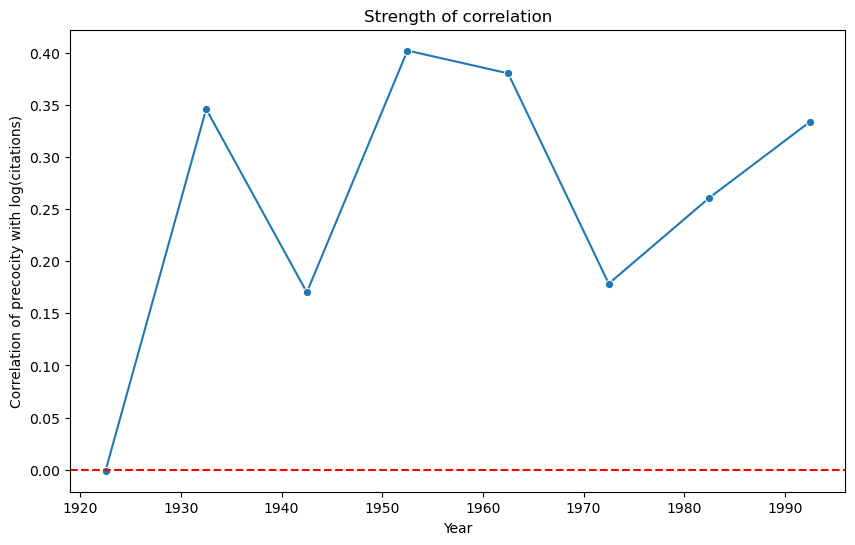

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     864.9
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:36:37   Log-Likelihood:                -55679.
No. Observations:               29164   AIC:                         1.114e+05
Df Residuals:                   29145   BIC:                         1.116e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5127      0.121      4.239      

In [8]:
reg_df = run_model('precocity_tuned_', rschmeta, chunksused = 0.25, fractioncompared = 1)

In [9]:
model_novelty_and_transience(reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     820.7
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:37:52   Log-Likelihood:                -55671.
No. Observations:               29164   AIC:                         1.114e+05
Df Residuals:                   29144   BIC:                         1.115e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4890      0.328      1.491   

In [10]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     774.1
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:38:21   Log-Likelihood:                -57031.
No. Observations:               29164   AIC:                         1.141e+05
Df Residuals:                   29148   BIC:                         1.142e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6970      0.066     25.582      

# Difference for top 25% = 0.348 - 0.285 = 0.063

#### using all chunks

1920 - 20/1/1, n = 1115, -0.04344
1930 - 20/1/1, n = 1389, 0.31174
1940 - 20/1/1, n = 1520, 0.16166
1950 - 20/1/1, n = 2593, 0.34007
1960 - 20/1/1, n = 4173, 0.32094
1970 - 20/1/1, n = 7215, 0.11442
1980 - 20/1/1, n = 6750, 0.17595
1990 - 20/1/1, n = 4409, 0.26085


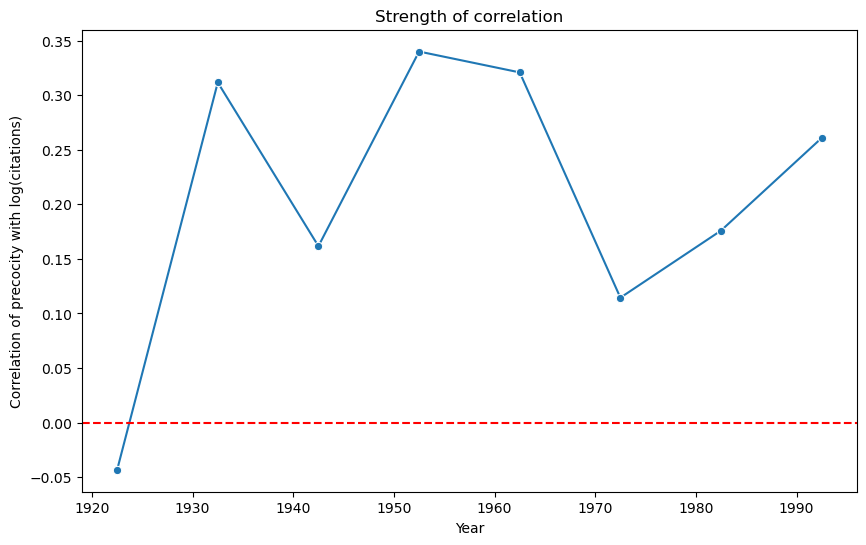

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     779.8
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:38:48   Log-Likelihood:                -56188.
No. Observations:               29164   AIC:                         1.124e+05
Df Residuals:                   29145   BIC:                         1.126e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1795      0.133      8.879      

In [11]:
reg_df = run_model('precocity_tuned_', rschmeta, chunksused = 1, fractioncompared = 1)

In [12]:
model_novelty_and_transience(reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     742.2
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:39:17   Log-Likelihood:                -56165.
No. Observations:               29164   AIC:                         1.124e+05
Df Residuals:                   29144   BIC:                         1.125e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4692      0.350      4.203   

In [13]:
null_reg_df = reg_df.copy()
null_reg_df['precocity'] = 0
null_reg_df['novelty'] = 0
controlled_model(null_reg_df)

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     774.1
Date:                Sat, 26 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:39:22   Log-Likelihood:                -57031.
No. Observations:               29164   AIC:                         1.141e+05
Df Residuals:                   29148   BIC:                         1.142e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6970      0.066     25.582      

# Difference for all chunks = 0.325 - 0.285 = 0.04

# Running just book reviews

1920 - 20/0.25/1.0, n = 114, 0.05023
1930 - 20/0.25/1.0, n = 23, -0.09095
1940 - 20/0.25/1.0, n = 25, 0.05178
1950 - 20/0.25/1.0, n = 682, 0.06439
1960 - 20/0.25/1.0, n = 146, 0.15522
1970 - 20/0.25/1.0, n = 57, 0.47455
1980 - 20/0.25/1.0, n = 27, 0.32177
1990 - 20/0.25/1.0, n = 17, 0.11709


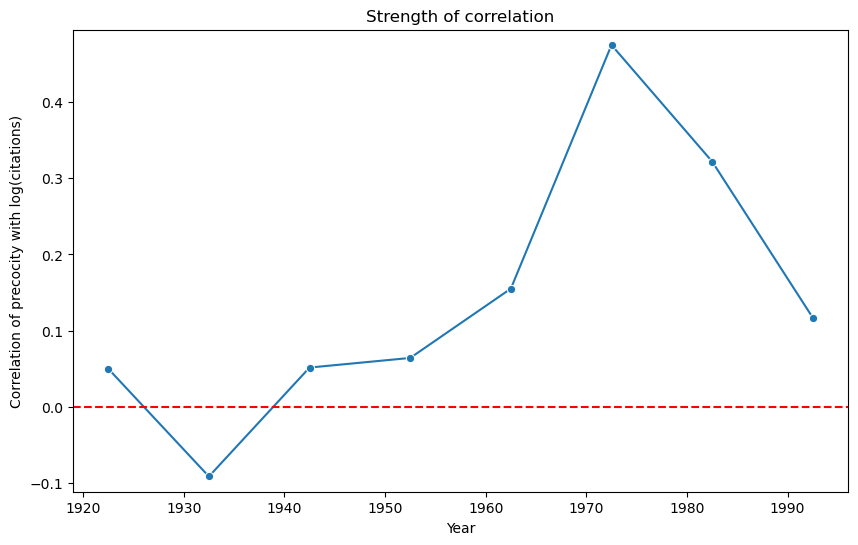

                            OLS Regression Results                            
Dep. Variable:           logcitations   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     4.974
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           1.72e-10
Time:                        18:04:28   Log-Likelihood:                -2174.2
No. Observations:                1091   AIC:                             4384.
Df Residuals:                    1073   BIC:                             4474.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2030      0.723      5.811      

In [85]:
reg_df = run_model('precocity_tuned_', bkrvmeta, chunksused = 0.25, fractioncompared = 1.0)